# Network Intrusion Detector
### CSc 180, Sect. 01 (Spring 2021)
### Lucas Saechao, Noah Venethongkham, Ashley Thor
### 03/12/2021

# Abstract
Software that protects computer networks from unauthorized intrusion or access provide real, universal value to individuals and enterprises across the world. This type of software is known as an Intrusion Detection System (IDS), and is intended to monitor a network for malicious activity. The advent and explosion of machine learning models, and software in the last decade provide opportunities to develop new techniques in order to determine good or bad actors in a system. 

This project aims to build a Network IDS (NIDS) using machine learning, by providing an accurate, predictive model that can distinguish bad connections, intrusions, or attacks, from genuine, well-intentioned network connections.

This model is trained using the KDD Cup 1999 Dataset.

# Import Libraries

In [54]:
# matplotlib
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt

# numpy and pandas
import numpy as np
import pandas as pd

# scikit learn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
import sklearn.feature_extraction.text as sk_text


# tensorflow and keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

# python libraries
import requests
import shutil
import json
import time
import csv
import io
import os

# if OS is windows, import chime
if os.name == 'nt':
    import winsound

read = './data/'
write = './weights/'

path = os.path.join(read, 'nid.csv')
weights = os.path.join(write, "weights.hdf5")

# Helper Functions

In [55]:
# Plots a confusion matrix for the model
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot an ROC curve
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_area_under_curve = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = $0.2f)' % roc_area_under_curve)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show
    
# Encodes text values into numerical variables
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for i in dummies.columns:
        dummy_name = "{}-{}".format(name, i)
        df[dummy_name] = dummies[i]
    df.drop(name, axis=1, inplace=True)
    
# Normalizes numerical values into a z-score
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd
    
# For formatting time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)
    
# Beep if on a windows machine
if os.name == 'nt':
    def ding():
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)


# Preprocessing Data Functions
Because this is to be treated as a binary classification problem, we will only care about normal outcomes compared to attacks - the data currently has several discrete attack types, so the following label encoder will provide it in normal and not-normal terms

In [56]:
def make_binary(input_str):
    out = 0 if input_str == 'normal.' else 1
    return out

# Import Data

In [57]:
df_csv = pd.read_csv(path, encoding='utf-8')
df_csv.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

In [58]:
# print dataframe tuples
df_csv

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


# Data Preprocessing
Before it can be used, the data first must be examined and cleaned. This means that redundant records and records with missing values will need to be removed

In [59]:
# remove redundant records
df_csv.drop_duplicates(subset=None, inplace=True)

# remove values with missing values
df_csv.dropna()

# determine and remove any useless columns that may incorrectly influence the output

# encode symbolic variables
symbolic = [
    'protocol_type',
    'service',
    'flag',
    'land',
    'logged_in',
    'is_host_login',
    'is_guest_login',
]

continuous = [
    'duration',
    'src_bytes',
    'dst_bytes'
]
for i in symbolic:
    encode_text_dummy(df_csv, i)
for j in continuous:
    encode_numeric_zscore(df_csv, j)
    
y = df_csv['outcome'].map(make_binary)
# 0 for normal
# 1 for attack
y.value_counts()

0    87831
1    57754
Name: outcome, dtype: int64

In [60]:
# verify data frame
df_csv

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004261,-0.039036,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
1,-0.10785,-0.004263,-0.025041,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
2,-0.10785,-0.004272,-0.025041,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
3,-0.10785,-0.004273,-0.013612,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
4,-0.10785,-0.004273,-0.013612,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,-0.10785,-0.004222,-0.016095,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
494016,-0.10785,-0.004237,-0.009435,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
494017,-0.10785,-0.004281,-0.027294,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
494018,-0.10785,-0.004232,-0.027294,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0


In [61]:
df_2 = df_csv
df_2 = df_2.to_numpy()
df_outcome = df_csv

In [62]:
# drop outcomes
df_csv = df_csv.drop('outcome', axis=1)

In [63]:
# convert to numpy array
df = df_csv.to_numpy()
df_x = df.reshape(len(df_csv), 1, len(df_csv.columns), 1)

In [64]:
df_x

array([[[[-0.10785025],
         [-0.00426104],
         [-0.03903572],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 0.        ]]],


       [[[-0.10785025],
         [-0.00426324],
         [-0.02504131],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 0.        ]]],


       [[[-0.10785025],
         [-0.00427203],
         [-0.02504131],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 0.        ]]],


       ...,


       [[[-0.10785025],
         [-0.00428082],
         [-0.02729423],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 0.        ]]],


       [[[-0.10785025],
         [-0.00423248],
         [-0.02729423],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 0.        ]]],


       [[[-0.10785025],
         [-0.00427203],
         [-0.02673511],
         ...,
         [ 1.        ],
         [ 1.        ],
         [ 0.        ]]]])

# Split into train/test set

In [65]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=0.25, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(df, y, test_size=0.25, random_state=42)
x_train = x_train.astype('float32')
x2_train = x2_train.astype('float32')
x_test = x_test.astype('float32')
x2_test = x2_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, 2)
#y2_train = tf.keras.utils.to_categorical(y2_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)
#y2_test = tf.keras.utils.to_categorical(y2_test, 2)

In [66]:
# print shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(109188, 1, 121, 1)
(109188, 2)
(36397, 1, 121, 1)
(36397, 2)


# Prepare DNN Model

In [1]:
model = Sequential()
model.add(Dense(200, input_dim=df.shape[1], activation='relu'))
model.add(Dense(150, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

model.summary()

NameError: name 'Sequential' is not defined

In [67]:
activations = ['relu', 'sigmoid', 'tanh']
activations2 = ['relu', 'sigmoid', 'tanh']
optimizers = ['adam', 'sgd']
combined = [(a,a2,o) for a in activations for a2 in activations2 for o in optimizers]

best_model = (0, 0)

print(activations)
print(optimizers)
print(combined)
print(len(combined))

['relu', 'sigmoid', 'tanh']
['adam', 'sgd']
[('relu', 'relu', 'adam'), ('relu', 'relu', 'sgd'), ('relu', 'sigmoid', 'adam'), ('relu', 'sigmoid', 'sgd'), ('relu', 'tanh', 'adam'), ('relu', 'tanh', 'sgd'), ('sigmoid', 'relu', 'adam'), ('sigmoid', 'relu', 'sgd'), ('sigmoid', 'sigmoid', 'adam'), ('sigmoid', 'sigmoid', 'sgd'), ('sigmoid', 'tanh', 'adam'), ('sigmoid', 'tanh', 'sgd'), ('tanh', 'relu', 'adam'), ('tanh', 'relu', 'sgd'), ('tanh', 'sigmoid', 'adam'), ('tanh', 'sigmoid', 'sgd'), ('tanh', 'tanh', 'adam'), ('tanh', 'tanh', 'sgd')]
18


In [68]:
best_combo = ['','','']

# loop thru all combinations of activations and optimizers
for i in combined: 
    var1 = i[0]
    var2 = i[1]
    var3 = i[2]
    model = Sequential()
    model.add(Dense(200, input_dim=df.shape[1], activation=var1))
    print(var1)
    model.add(Dense(150, activation=var2)) # print a twin
    print(var2)

    # the output layer with a softmax activiation is a constant 
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='sparse_categorical_crossentropy', optimizer=var3, metrics=['accuracy'])
    print(var3)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, verbose=2, mode='auto')

    checkpoint = ModelCheckpoint(filepath="weights/dnn_weights.hdf5", verbose=0, save_best_only=True)

    model.fit(x2_train, y2_train, batch_size=128, callbacks=[monitor, checkpoint], epochs=1000, verbose=0, validation_data=(x2_test, y2_test))

    model.load_weights('weights/dnn_weights.hdf5')

    # evaluate() computes the loss and accuracy
    model_score = model.evaluate(x2_test, y2_test, verbose=0)
    model_score
    print('Test loss: {}'.format(model_score[0]))
    print('Test accuracy: {}'.format(model_score[1]))
    
    if model_score[1] > best_model[0]:        
        best_model = (model_score[1],model)
        print('New best score: {}'.format(best_model[0]))
        print('The combination of ' + var1 + ', ' + var2 + ', ' + var3 + " gave the best score")
        best_combo = [var1,var2,var3]

        
print('The combination of ' + best_combo[0] + ', ' + best_combo[1] + ', ' + best_combo[2] + " gave the best score")

model = best_model[1]

relu
relu
adam
Test loss: 0.02665793317091516
Test accuracy: 0.9942302703857422
New best score: 0.9942302703857422
The combination of relu, relu, adam gave the best score
relu
relu
sgd
Test loss: 0.0962524243766878
Test accuracy: 0.9679094552993774
relu
sigmoid
adam
Test loss: 0.0258542923163487
Test accuracy: 0.994642436504364
New best score: 0.994642436504364
The combination of relu, sigmoid, adam gave the best score
relu
sigmoid
sgd
Test loss: 0.330748894686954
Test accuracy: 0.9046624898910522
relu
tanh
adam
Test loss: 0.044214829573962056
Test accuracy: 0.9859328866004944
relu
tanh
sgd
Test loss: 0.08568699407810712
Test accuracy: 0.9721130728721619
sigmoid
relu
adam
Test loss: 0.01584134940628795
Test accuracy: 0.9956040382385254
New best score: 0.9956040382385254
The combination of sigmoid, relu, adam gave the best score
sigmoid
relu
sgd
Test loss: 0.09329522891619481
Test accuracy: 0.9679918885231018
sigmoid
sigmoid
adam
Test loss: 0.018576033719997935
Test accuracy: 0.99401050

In [69]:
print(model)
model.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_258 (Dense)            (None, 200)               24400     
_________________________________________________________________
dense_259 (Dense)            (None, 150)               30150     
_________________________________________________________________
dense_260 (Dense)            (None, 2)                 302       
Total params: 54,852
Trainable params: 54,852
Non-trainable params: 0
_________________________________________________________________


# Fit and Train DNN Model

In [153]:
start_time = time.time()
batch = 128

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, verbose=2, mode='auto')
checkpoint = ModelCheckpoint(filepath="weights/dnn_weights.hdf5", verbose=0, save_best_only=True)

# fit dnn
model.fit(x2_train, y2_train, batch_size=batch, callbacks=[monitor, checkpoint], epochs=1000, verbose=2, validation_data=(x2_test, y2_test))

# load weights
model.load_weights('weights/dnn_weights.hdf5')
elapsed_time = time.time() - start_time
print("Elapsed Time: {}".format(hms_string(elapsed_time)))

Train on 109188 samples, validate on 36397 samples
Epoch 1/1000
109188/109188 - 2s - loss: 0.0078 - acc: 0.9978 - val_loss: 0.0072 - val_acc: 0.9984
Epoch 2/1000
109188/109188 - 2s - loss: 0.0071 - acc: 0.9981 - val_loss: 0.0074 - val_acc: 0.9980
Epoch 3/1000
109188/109188 - 2s - loss: 0.0066 - acc: 0.9981 - val_loss: 0.0106 - val_acc: 0.9969
Epoch 4/1000
109188/109188 - 2s - loss: 0.0082 - acc: 0.9979 - val_loss: 0.0062 - val_acc: 0.9980
Epoch 5/1000
109188/109188 - 2s - loss: 0.0064 - acc: 0.9982 - val_loss: 0.0066 - val_acc: 0.9980
Epoch 6/1000
109188/109188 - 2s - loss: 0.0063 - acc: 0.9982 - val_loss: 0.0055 - val_acc: 0.9984
Epoch 7/1000
109188/109188 - 2s - loss: 0.0061 - acc: 0.9983 - val_loss: 0.0059 - val_acc: 0.9982
Epoch 8/1000
109188/109188 - 2s - loss: 0.0062 - acc: 0.9980 - val_loss: 0.0071 - val_acc: 0.9982
Epoch 9/1000
109188/109188 - 2s - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0120 - val_acc: 0.9956
Epoch 10/1000
109188/109188 - 2s - loss: 0.0055 - acc: 0.9984 - val

In [70]:
# evaluate() computes the loss and accuracy
model_score = model.evaluate(x2_test, y2_test, verbose=0)
model_score
print('Test loss: {}'.format(model_score[0]))
print('Test accuracy: {}'.format(model_score[1]))

Test loss: 0.01584134940628795
Test accuracy: 0.9956040382385254


# DNN Predictions

In [29]:
y2_test = tf.keras.utils.to_categorical(y2_test, 2)

In [30]:
y_true = np.argmax(y2_test[0:109188],axis=1)
pred = model.predict(x2_test[0:109188])
pred = np.argmax(pred,axis=1)

# DNN Model Evaluation
As a classification model, this model will be evaluated on the following metrics: 
 * Accuracy
 * Precision
 * Recall
 * F1 Score
 * Log Loss
 * Confusion Matrix
 * ROC Curve

In [31]:
model_score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(model_score))

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

#accuracy, precision, recall, f1 score
print(metrics.classification_report(y_true, pred))

#log loss
logLoss = metrics.log_loss(y_true, pred)
print('Log Loss: {}'.format(logLoss))

Accuracy: 0.9952468610050279
Averaged F1: 0.9952466646830354
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       0.99      0.99      0.99     14459

    accuracy                           1.00     36397
   macro avg       1.00      0.99      1.00     36397
weighted avg       1.00      1.00      1.00     36397

Log Loss: 0.1641694283294307


[[21855    83]
 [   90 14369]]
Plotting confusion matrix


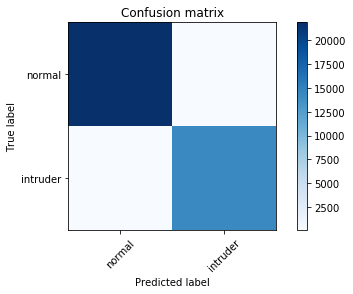

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       0.99      0.99      0.99     14459

    accuracy                           1.00     36397
   macro avg       1.00      0.99      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [32]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['normal','intruder'])
plt.show()

print(classification_report(y_true, pred))

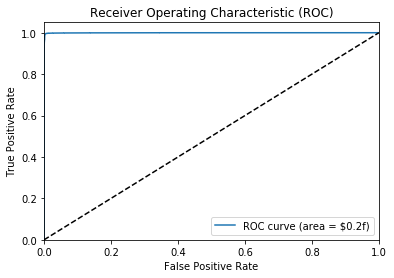

In [33]:
#ROC curve
pred = model.predict(x2_test)
pred = pred[:,1]
plot_roc(pred,y_true)

# Prepare Convolutional Model

In [13]:
convnet = Sequential()
# add convnet layers
input_shape = (1,121,1)

convnet.add(Conv2D(200, kernel_size=(1, 5), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))
convnet.add(Conv2D(150, (1, 4), activation='relu'))
convnet.add(MaxPooling2D(pool_size=(1, 2), strides=None))
convnet.add(Dropout(0.25))

convnet.add(Flatten())

convnet.add(Dense(100, activation='relu'))

convnet.add(Dropout(0.25))

convnet.add(Dense(2, activation='softmax'))

# compile convnet
convnet.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
# print convnet summary
convnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 117, 200)       1200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 114, 150)       120150    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 57, 150)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 57, 150)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8550)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               855100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

# Fit and train CNN model

In [15]:
start_time = time.time()
batch = 128

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, verbose=2, mode='auto')
checkpoint = ModelCheckpoint(filepath=weights, verbose=0, save_best_only=True)

# fit convnet
convnet.fit(x_train, y_train, batch_size=batch, callbacks=[monitor, checkpoint], epochs=1000, verbose=2, validation_data=(x_test, y_test))

# load weights
convnet.load_weights(weights)
elapsed_time = time.time() - start_time
print("Elapsed Time: {}".format(hms_string(elapsed_time)))

Train on 109188 samples, validate on 36397 samples
Epoch 1/1000
109188/109188 - 10s - loss: 0.0571 - acc: 0.9860 - val_loss: 0.0095 - val_acc: 0.9972
Epoch 2/1000
109188/109188 - 8s - loss: 0.0134 - acc: 0.9964 - val_loss: 0.0079 - val_acc: 0.9974
Epoch 3/1000
109188/109188 - 8s - loss: 0.0114 - acc: 0.9968 - val_loss: 0.0071 - val_acc: 0.9977
Epoch 4/1000
109188/109188 - 8s - loss: 0.0107 - acc: 0.9969 - val_loss: 0.0074 - val_acc: 0.9977
Epoch 5/1000
109188/109188 - 8s - loss: 0.0100 - acc: 0.9970 - val_loss: 0.0086 - val_acc: 0.9966
Epoch 6/1000
109188/109188 - 8s - loss: 0.0086 - acc: 0.9974 - val_loss: 0.0067 - val_acc: 0.9981
Epoch 7/1000
109188/109188 - 8s - loss: 0.0087 - acc: 0.9975 - val_loss: 0.0061 - val_acc: 0.9983
Epoch 8/1000
109188/109188 - 7s - loss: 0.0075 - acc: 0.9980 - val_loss: 0.0064 - val_acc: 0.9979
Epoch 9/1000
109188/109188 - 8s - loss: 0.0075 - acc: 0.9980 - val_loss: 0.0058 - val_acc: 0.9982
Epoch 10/1000
109188/109188 - 8s - loss: 0.0070 - acc: 0.9979 - va

In [16]:
# evaluate() computes the loss and accuracy
score = convnet.evaluate(x_test[0:100], y_test[0:100], verbose=0)
score
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 9.714000295844016e-06
Test accuracy: 1.0


In [17]:
# Ding when complete
if os.name == 'nt':
    ding()
else:
    print("Completed")


# Perform CNN predictions

In [18]:
y_true = np.argmax(y_test[0:109188],axis=1)
pred = convnet.predict(x_test[0:109188])
pred = np.argmax(pred,axis=1)

# CNN Model Evaluation
As a classification model, this model will be evaluated on the following metrics: 
 * Accuracy
 * Precision
 * Recall
 * F1 Score
 * Log Loss
 * Confusion Matrix
 * ROC Curve

In [19]:
score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

#accuracy, precision, recall, f1 score
print(metrics.classification_report(y_true, pred))

#log loss
logLoss = metrics.log_loss(y_true, pred)
print('Log Loss: {}'.format(logLoss))

Accuracy: 0.9990109074923758
Averaged F1: 0.9990108257029516
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397

Log Loss: 0.03416228661121941


[[21927    11]
 [   25 14434]]
Plotting confusion matrix


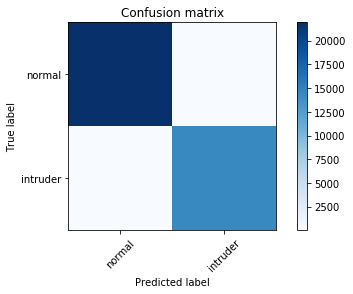

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['normal','intruder'])
plt.show()

print(classification_report(y_true, pred))

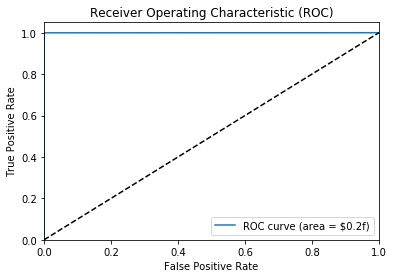

In [21]:
#ROC curve
pred = convnet.predict(x_test)
pred = pred[:,1]
plot_roc(pred,y_true)